In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.animation as animation
import matplotlib.patches as mpatches
from IPython.display import HTML
import seaborn as sns
from db import *

vgsales = get_db()
vgsales

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37
...,...,...,...,...,...,...,...,...,...,...,...
16593,16596,Woody Woodpecker in Crazy Castle 5,GBA,2002,Platform,Kemco,0.01,0.00,0.00,0.00,0.01
16594,16597,Men in Black II: Alien Escape,GC,2003,Shooter,Infogrames,0.01,0.00,0.00,0.00,0.01
16595,16598,SCORE International Baja 1000: The Official Game,PS2,2008,Racing,Activision,0.00,0.00,0.00,0.00,0.01
16596,16599,Know How 2,DS,2010,Puzzle,7G//AMES,0.00,0.01,0.00,0.00,0.01


# Objetivo do Trabalho

O objetivo desse trabalho será fazer uma análise geral de diversos aspectos do mercado de jogos, que depois irá se aprofundar em determinados pontos específicos, como a comparação de diversas franquias famosas. Cada análise será guiada por certas "perguntas" que buscamos responder, através das técnicas aprendidas ao longo do semestre.

# A dinâmica do mercado

Primeiramente, iremos analisar como a dinâmica do mercado mudou ao longo do tempo. Faremos isso através de uma chamada "bar chart race", um tipo de animação onde cada frame representa um ano específico, com o gráfico de barras representando a quantidade de vendas de cada gênero. Dessa forma, será possível entender os períodos em que determinados gêneros foram os mais populares, e assim, descobrir se há algum tipo de tendência ou padrão no mercado de jogos em relação a popularidade com o passar do tempo. 

## Manipulação dos dados

Entretanto, para montar uma visualização como essa, é preciso primeiro tratar a base de dados original. Como se pode ver na tabela a seguir, a quantidade de vendas retratada não representa a quantidade total de vendas cumulativas até aquele ano, e sim as vendas específicas que ocorreram nele (ou seja, os dados de vendas de 2016 não terão nenhuma informação sobre o ano de 2015). Além disso, há ainda diversos jogos cujo ano de lançamento não está disponível na base. Esses jogos serão descartados na análise que será feita posteriormente.

In [39]:
vgsales[(vgsales["Year"] != -1)].groupby(["Year"],as_index=False)[["Global_Sales"]].sum().head()

,Year,Global_Sales
0,1980,11.38
1,1981,35.77
2,1982,28.86
3,1983,16.79
4,1984,50.36


Agora, faremos uma série de operações para criar um novo dataframe, que contém as vendas cumulativas de cada gênero por ano. Para isso, criaremos um subset do dataframe original através do comando .groupby, agrupando os dados pelo ano e gênero de cada jogo, e somando o valor de "Global_Sales" de cada combinação. Além disso, serão definidas algumas variáveis que serão utilizadas posteriormente no processo.

In [40]:
vgsales_year = vgsales[(vgsales["Year"] != -1)].groupby(["Year", "Genre"],as_index=False)[["Global_Sales"]].sum()

genres = set()
years = []
cumulative = []
genreslist = []

vgsales_year.head(10)

,Year,Genre,Global_Sales
0,1980,Action,0.34
1,1980,Fighting,0.77
2,1980,Misc,2.71
3,1980,Shooter,7.07
4,1980,Sports,0.49
5,1981,Action,14.84
6,1981,Platform,6.93
7,1981,Puzzle,2.24
8,1981,Racing,0.48
9,1981,Shooter,10.04


Entretanto, esse método possui um problema. Vejamos a tabela a seguir:

In [41]:
vgsales_year_sorted = vgsales_year.sort_values(["Genre", "Year"])
vgsales_year_sorted[vgsales_year_sorted.Genre.str.contains("Adventure")].head()

,Year,Genre,Global_Sales
20,1983,Adventure,0.40
47,1987,Adventure,4.38
76,1991,Adventure,2.24
88,1992,Adventure,12.24
100,1993,Adventure,0.07


Observe o "pulo" entre o ano de 1983 e 1987. Caso isso não seja tratado, a animação final terá problemas de "descontinuidade", onde uma barra existente em um determinado ano para de existir no ano seguinte. Portanto, teremos que levar isso em conta quando implementarmos a lógica da criação do novo dataset.

Com o subset e as variáveis auxiliares prontas, podemos começar as operações. Primeiramente, será criado um conjunto de todos os gêneros diferentes (a variável "genres"), que será usada em um for loop que fará a "varredura" de cada linha da tabela vgsales_year e atribuirá os valores de venda acumulada corretamente para cada ano e gênero distinto. Por último, criaremos um dataframe com base nesses dados, que será utilizado para a animação.

In [42]:
for tupla in vgsales_year.itertuples():
    genres.add(tupla.Genre) # Criação do conjunto genres


for genre in genres:
    sales = 0 # Reinicia o valor das vendas cumulativas a 0, quando muda de gênero
    for tupla in vgsales_year.itertuples():
        if tupla.Genre == genre: # Checa se está analisando o gênero correto
            if len(years) != 0:
                while (years[-1] + 1 != tupla.Year) and (genreslist[-1] == tupla.Genre): # Loop que corrige os "pulos" de anos
                    years.append(years[-1] + 1)
                    cumulative.append(sales)
                    genreslist.append(tupla.Genre)
                    
            years.append(tupla.Year)
            sales += tupla.Global_Sales # Representa o total de vendas cumulativas do gênero específico até aquele ano
            cumulative.append(sales)
            genreslist.append(tupla.Genre)


dic = {"Year": years,
       "Genre": genreslist,
       "Cumulative_Sales": cumulative
       } # Criação do dicionário

df = pd.DataFrame(dic) # Conversão a Dataframe

df[df.Genre.str.contains("Adventure")].head()

,Year,Genre,Cumulative_Sales
244,1983,Adventure,0.40
245,1984,Adventure,0.40
246,1985,Adventure,0.40
247,1986,Adventure,0.40
248,1987,Adventure,4.78


Como pode ser visto na tabela acima, a lógica aparenta ter dado certo! Agora iremos criar a palheta de cores. 

Algo importante a se notar é que o comportamento padrão do argumento *colors* de um gráfico de barras atribui as cores se baseando na "posição" de cada barra (por exemplo, a primeira barra é sempre azul, a segunda é sempre vermelha). Como nosso objetivo é criar uma animação com base no tempo, faz mais sentido que as cores sejam atribuídas ao *gênero* que a barra representa, para que a comparação entre anos diferentes seja muito mais intuitiva. Portanto, criaremos uma palheta de cores genérica para atribuir a cada gênero específico.


In [43]:
hex = ['#D2D8B3', '#C38D94', '#C3D350', '#A1E8AF',
     '#3C91E6', '#FE5F55', '#90DDF0', '#808F85',
     '#F4B942', '#6A994E', '#747C92', '#E086D3']
colors = dict(zip(genres, hex))
print(colors)

{'Strategy': '#D2D8B3', 'Misc': '#C38D94', 'Simulation': '#C3D350', 'Role-Playing': '#A1E8AF', 'Fighting': '#3C91E6', 'Shooter': '#FE5F55', 'Puzzle': '#90DDF0', 'Adventure': '#808F85', 'Sports': '#F4B942', 'Action': '#6A994E', 'Racing': '#747C92', 'Platform': '#E086D3'}


## Criando o Gráfico

Agora que toda a preparação está pronta, está na hora de criar a função que desenhará o gráfico. O código foi inspirado no tutorial presente no link <https://towardsdatascience.com/bar-chart-race-in-python-with-matplotlib-8e687a5c8a41>, e sua funcionalidade será descrita através de comentários dentro da code chunk. 

In [44]:
fig, ax = plt.subplots(figsize = (15, 9)) # Cria e define o tamanho do plot
plt.close()
def draw_barchart(year):
        dff = (df[df["Year"].eq(year)].sort_values(by="Cumulative_Sales", ascending=True)) # Ordena os dados com base nas vendas
        ax.clear() # Certifica-se que o plot está vazio antes dos dados serem inseridos

        ax.barh(dff["Genre"], dff["Cumulative_Sales"], color = [colors[x] for x in dff["Genre"]]) # Define os eixos e atribui as cores para cada gênero
        dx = dff["Cumulative_Sales"].max() / 200 # Valor usado para posicionar de forma melhor os textos de cada barra

        for i, (sales, genre) in enumerate(zip(dff["Cumulative_Sales"], dff["Genre"])): # Loop que insire o texto específico de cada barra
                ax.text(sales-dx, i-.07, genre, size=13, weight=600, ha="right", va="bottom")
                ax.text(sales-dx, i,  "  " + str(round(sales)), size=13, ha="left", va="center")

        ax.text(1, 0.4, year, transform=ax.transAxes, color='#777777', size=46, ha="right", weight=800) # Mostra o ano do qual os dados estão sendo analisados
        ax.text(0, 1.06, "Total sales (in millions)", transform=ax.transAxes, size=12, color="#777777", ha="left", va="center") # Legenda

        # Os comandos a seguir modificam a aparência dos eixos e de seus "ticks"
        ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}')) 
        ax.xaxis.set_ticks_position("top")
        ax.tick_params(axis="x", colors="#333333", labelsize=12)
        ax.set_yticks([])
        ax.margins(0, 0.01)
        ax.grid(which="major", axis="x", linestyle="-")
        ax.set_axisbelow(True)

        ax.text(0, 1.12, "Total accumulated sales per genre, from 1980 to 2015", transform=ax.transAxes, size=24, weight=600, ha="left", va="top") # Título
        plt.box(False) # Remover a "borda" do gráfico


Com *draw_barchart* preparado, basta utilizar a função *FuncAnimation*, que irá invocar a função especificada em seus argumentos repetidas vezes, e usar *HTML()* para mostrar a animação que foi feita.

In [45]:
animator = animation.FuncAnimation(fig, draw_barchart, frames=range(1980, 2016)) # As frames representam o argumento que será "enviado" para a função especificada
animation = HTML(animator.to_jshtml())
plt.close()

In [46]:
animation # A animação está em uma chunk diferente para evitar que o jupyter também mostre como output um plot vazio, que é gerado durante a aplicação das funções draw_barchart

Com isso, a animação está completa, e nos permite perceber alguns movimentos interessantes na dinâmica do mercado ao longo do tempo.

## Análise das dinâmicas

Primeiramente, iremos analisar o comportamento do gênero de maior popularidade. Os jogos de plataforma se mantiverem na liderança por um período significante de tempo, de 1985 até 2005, ano em que foram ultrapassados pelos jogos de ação. A pergunta que vem a cabeça é: o que causou essa mudança?

O ano de 1985 é um ano extremamente importante na indústria de jogos. É nele em que o primeiro console de mesa da Nintendo, o Nintendo Entertainment System (NES), foi lançado ao público, junto com o jogo de plataforma "Super Mario Bros", um enorme sucesso que estabeleceu diversas normas e regras de design que inspiraram as futuras gerações de jogos do mesmo gênero.

Esse lançamento, unido com suas diversas sequências (dando destaque a Super Mario Bros 3, Super Mario World e Super Mario Land), outras franquias da Nintendo (como Donkey Kong Country), e franquias rivais (como Sonic), consolidaram o gênero de plataforma como o mais popular no universo de consoles 2D.



In [47]:
vgsales[(vgsales.Genre.str.contains("Platform")) & (vgsales.Year < 1996)].head(10)

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
1,2,Super Mario Bros.,NES,1985,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
18,19,Super Mario World,SNES,1990,Platform,Nintendo,12.78,3.75,3.54,0.55,20.61
21,22,Super Mario Land,GB,1989,Platform,Nintendo,10.83,2.71,4.18,0.42,18.14
22,23,Super Mario Bros. 3,NES,1988,Platform,Nintendo,9.54,3.44,3.84,0.46,17.28
57,58,Super Mario All-Stars,SNES,1993,Platform,Nintendo,5.99,2.15,2.12,0.29,10.55
71,72,Donkey Kong Country,SNES,1994,Platform,Nintendo,4.36,1.71,3.00,0.23,9.30
96,97,Super Mario Bros. 2,NES,1988,Platform,Nintendo,5.39,1.18,0.70,0.19,7.46
143,144,Sonic the Hedgehog 2,GEN,1992,Platform,Sega,4.47,1.20,0.16,0.19,6.03
184,185,Super Mario Land 3: Wario Land,GB,1994,Platform,Nintendo,2.49,0.98,1.57,0.15,5.19
187,188,Donkey Kong Country 2: Diddy's Kong Quest,SNES,1995,Platform,Nintendo,2.10,0.74,2.20,0.11,5.15


Naturalmente, esse "reinado" do gênero de plataforma não durou para sempre, e tudo começou a mudar a partir do ano de 1996, ano onde começou a primeira geração dos "consoles 3D" (PS1, XBOX, N64). 

O ambiente 3D se provou uma plataforma de desenvolvimento que incentivava os desenvolvedores a se inovarem. As inúmeras técnicas acumuladas através dos anos para jogos 2D foram subitamente descartadas, ao mesmo tempo em que infinitas possibilidades foram abertas. Apesar de diversos novos jogos de plataforma terem sido um sucesso, como Super Mario 64 e os jogos da franquia Crash Bandicoot, a maioria das desenvolvedoras decidiu se arriscar nesse mercado volátil, com o objetivo de encontrar a nova "fórmula" para o sucesso, se aventurando em gêneros que não eram tão famosos no mercado, como ação e esportes. 

Podemos ver bem isso nas tabelas abaixo:

In [48]:
vgsales[(vgsales.Genre.str.contains("Platform")) & (vgsales.Year > 1995) & (vgsales.Year < 2006)]

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
46,47,Super Mario 64,N64,1996,Platform,Nintendo,6.91,2.85,1.91,0.23,11.89
59,60,Super Mario 64,DS,2004,Platform,Nintendo,5.08,3.11,1.25,0.98,10.42
95,96,Crash Bandicoot 2: Cortex Strikes Back,PS,1997,Platform,Sony Computer Entertainment,3.78,2.17,1.31,0.31,7.58
106,107,Crash Bandicoot 3: Warped,PS,1998,Platform,Sony Computer Entertainment,3.68,1.75,1.42,0.28,7.13
116,117,Crash Bandicoot,PS,1996,Platform,Sony Computer Entertainment,3.23,2.35,0.94,0.30,6.82
...,...,...,...,...,...,...,...,...,...,...,...
15919,15922,Rayman 10th Anniversary,GBA,2005,Platform,Ubisoft,0.01,0.00,0.00,0.00,0.02
16159,16162,Malice,XB,2004,Platform,Evolved Games,0.01,0.00,0.00,0.00,0.01
16238,16241,Kao the Kangaroo,GBA,2001,Platform,Titus,0.01,0.00,0.00,0.00,0.01
16593,16596,Woody Woodpecker in Crazy Castle 5,GBA,2002,Platform,Kemco,0.01,0.00,0.00,0.00,0.01


In [49]:
vgsales[(vgsales.Genre.str.contains("Action")) & (vgsales.Year > 1995) & (vgsales.Year < 2006)]

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
17,18,Grand Theft Auto: San Andreas,PS2,2004,Action,Take-Two Interactive,9.43,0.40,0.41,10.57,20.81
24,25,Grand Theft Auto: Vice City,PS2,2002,Action,Take-Two Interactive,8.41,5.49,0.47,1.78,16.15
38,39,Grand Theft Auto III,PS2,2001,Action,Take-Two Interactive,6.99,4.51,0.30,1.30,13.10
90,91,Grand Theft Auto: Liberty City Stories,PSP,2005,Action,Take-Two Interactive,2.90,2.83,0.24,1.75,7.72
94,95,The Legend of Zelda: Ocarina of Time,N64,1998,Action,Nintendo,4.10,1.89,1.45,0.16,7.60
...,...,...,...,...,...,...,...,...,...,...,...
16439,16442,Shin Sangoku Musou 4 Special,X360,2005,Action,Tecmo Koei,0.00,0.00,0.01,0.00,0.01
16447,16450,Legacy of Kain: Defiance,PC,2003,Action,Eidos Interactive,0.00,0.01,0.00,0.00,0.01
16549,16552,E.T. The Extra-Terrestrial,GBA,2001,Action,NewKidCo,0.01,0.00,0.00,0.00,0.01
16582,16585,Planet Monsters,GBA,2001,Action,Titus,0.01,0.00,0.00,0.00,0.01


In [50]:
vgsales[(vgsales.Genre.str.contains("Sports")) & (vgsales.Year > 1995) & (vgsales.Year < 2006)]

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
202,203,Tony Hawk's Pro Skater,PS,1999,Sports,Activision,3.42,1.38,0.02,0.20,5.02
211,212,Madden NFL 06,PS2,2005,Sports,Electronic Arts,3.98,0.26,0.01,0.66,4.91
225,226,Tony Hawk's Pro Skater 2,PS,2000,Sports,Activision,3.05,1.41,0.02,0.20,4.68
238,239,Madden NFL 2005,PS2,2004,Sports,Electronic Arts,4.18,0.26,0.01,0.08,4.53
248,249,Tony Hawk's Pro Skater 3,PS2,2001,Sports,Activision,2.66,1.29,0.01,0.46,4.41
...,...,...,...,...,...,...,...,...,...,...,...
16351,16354,World Snooker Challenge 2005,PSP,2005,Sports,Sega,0.00,0.01,0.00,0.00,0.01
16426,16429,ESPN NBA 2Night 2002,XB,2002,Sports,Konami Digital Entertainment,0.01,0.00,0.00,0.00,0.01
16445,16448,Wade Hixton's Counter Punch,GBA,2004,Sports,"Destination Software, Inc",0.01,0.00,0.00,0.00,0.01
16461,16464,Razor Freestyle Scooter,GBA,2001,Sports,Ubisoft,0.01,0.00,0.00,0.00,0.01


A quantidade de lançamentos de jogos de plataforma é muito inferior a desses outros dois gêneros. Foram lançados quase o dobro de jogos de ação, e mais que o dobro de jogos de esporte (mas que individualmente não venderam tão bem quanto os dos outros).

A partir do ano de 2005, o gênero de ação toma a liderança, depois do lançamento de diversos sucessos consecutivos da franquia GTA, e tal liderança continua até os dias de hoje. Apesar da base de dados não ter dados bons o suficiente para representar os anos além de 2015, a tendência é clara: a disparidade entre a primeira e segunda colocações vem aumentando cada vez mais, e o mercado de jogos da atualidade não sofreu nenhuma outra mudança brusca o suficiente para desestablizar tal situação. 

In [51]:
vgsales[(vgsales.Genre.str.contains("Action")) & (vgsales.Year > 1996)].head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
16,17,Grand Theft Auto V,PS3,2013,Action,Take-Two Interactive,7.01,9.27,0.97,4.14,21.40
17,18,Grand Theft Auto: San Andreas,PS2,2004,Action,Take-Two Interactive,9.43,0.40,0.41,10.57,20.81
23,24,Grand Theft Auto V,X360,2013,Action,Take-Two Interactive,9.63,5.31,0.06,1.38,16.38
24,25,Grand Theft Auto: Vice City,PS2,2002,Action,Take-Two Interactive,8.41,5.49,0.47,1.78,16.15
38,39,Grand Theft Auto III,PS2,2001,Action,Take-Two Interactive,6.99,4.51,0.30,1.30,13.10


# Análise de Franquias

Nessa parte da análise exploratória buscamos, principalmente, investigar duas franquias muito famosas de jogos, levando em conta seu desenvolvimento e vendas através dos anos. A análise procura compreender tendências de vendas de acordo com lançamentos de jogos específicos e a relação entre as vendas e consoles.


## LEGO

Iniciaremos estudando a franquia de jogos da LEGO, que está no mercado dos jogos há mais de 20 anos, e para isso vamos modificar a base de dados, criando um subset que contenha apenas jogos com a palavra "LEGO" no nome (o que, no caso da LEGO, ocorre em todos os jogos), que nos auxiliará na construção de gráficos da franquia.

Encontramos 148 jogos e trabalharemos com eles para essa análise. A parte do subset exibida a seguir nos apresenta algumas tendências que podemos buscar comprovar. Por exemplo, pelos últimos itens da base, entre as opções de `Platform` dos jogos, os de PC parecem não ter muita aceitação, então podemos tentar explorar essa suposição. Vamos realizar uma plotagem para testar essa hipótese:

In [52]:
lego = vgsales[vgsales.Name.str.contains("LEGO")]
lego.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
150,151,LEGO Star Wars: The Complete Saga,Wii,2007,Action,LucasArts,3.66,1.63,0.00,0.53,5.83
212,213,LEGO Star Wars: The Complete Saga,DS,2007,Action,LucasArts,2.89,1.54,0.00,0.46,4.90
324,325,LEGO Indiana Jones: The Original Adventures,X360,2008,Action,Activision,2.40,1.03,0.00,0.36,3.78
364,365,LEGO Star Wars: The Video Game,PS2,2005,Action,Eidos Interactive,1.98,1.14,0.01,0.41,3.53
394,395,LEGO Batman: The Videogame,X360,2008,Action,Warner Bros. Interactive Entertainment,2.03,1.03,0.00,0.32,3.38


Vamos inicialmente fazer uma visualização das vendas globais dos jogos da LEGO através dos anos:

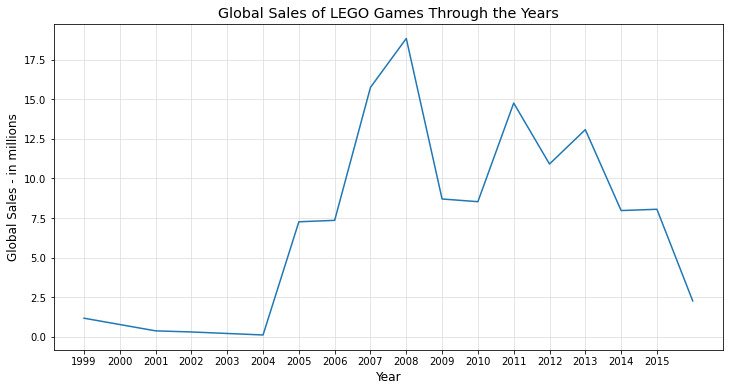

In [53]:
#Criamos um subset agrupando por ano e somando as vendas globais, além de retirarmos os anos NA (que havíamos definido como -1)
lego_y = lego.groupby(["Year"],as_index=False)[["Global_Sales"]].sum()
lego_y = lego_y[lego_y.Year!= -1]

#Criamos o frame
plt.figure(figsize=(12, 6))

#Fazemos a plotagem
plt.plot(lego_y["Year"], lego_y["Global_Sales"])  

#Definindo os eixos e detalhes de labels, etc.
plt.xticks(range(1999,2016))
plt.xlabel("Year", size="large")
plt.ylabel("Global Sales - in millions", size="large")
plt.title("Global Sales of LEGO Games Through the Years", size="x-large")
plt.grid(color='#E0DFDC')

plt.show()

Fica clara, a partir do gráfico, a época em que os jogos se tornaram mais populares, que coincide com o início da 7ª geração dos videogames - início em 2005 -, que compreende o lançamento do Xbox 360, do Playstation 3 e do Nintendo Wii, além do Nintendo DS e PSP entre os portáteis. Apesar de haver uma caída em 2008, os jogos permanecem populares até haver um real decréscimo a partir de 2013.

Podemos investigar essas vendas mais a fundo, analisando sua subdivisão entre as regiões de vendas:

Criaremos um mini subset que agrupa os jogos por plataforma, fazendo a contagem pela coluna `Name`, e outro mini subset que faz o mesmo agrupamento, mas contabiliza a soma das vendas globais. Em seguida, adicionei a coluna das vendas globais no primeiro subset.

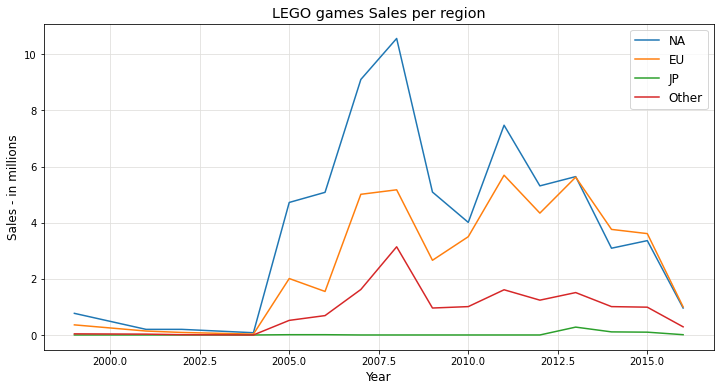

In [54]:
#Retiramos os NA
lego = lego[lego.Year!= -1]

#Criamos o frame
plt.figure(figsize=(12, 6))

#O processo aqui é o mesmo das vendas globais, mas repetido para cada linha, que é o formato default do plot
lego.groupby('Year')['NA_Sales'].sum().plot(label="NA")
lego.groupby('Year')['EU_Sales'].sum().plot(label="EU")
lego.groupby('Year')['JP_Sales'].sum().plot(label="JP")
lego.groupby('Year')['Other_Sales'].sum().plot(label="Other")

#Adição de detalhes, legendas...
plt.legend(prop={'size': 12})
plt.title("LEGO games Sales per region", size="x-large")
plt.xlabel("Year", size="large")
plt.ylabel("Sales - in millions", size="large")
plt.grid(color='#E0DFDC')

plt.show()

Fica clara, aqui, a predominância do mercado NA (América do Norte), o que não é uma surpresa, uma vez que este é o mercado de jogos de prevalência mundial. No entanto, é interessante avaliar o crescimento coletivo anterior a 2008, imagem da distribuição mundial de jogos da LEGO. É notável, no entanto que de 2004 a 2006, o crescimento das vendas NA foram muito rápidas, enquanto no resto do mundo essa subida aconteceu mais lentamente. 

Além disso, na última década, as vendas na região EU (Europa) chegaram a alcançar as mundiais em jogos LEGO! Vamos investigar mais a fundo esse fato, começando por criar um subset para análise do invetimento em plataformas.

In [55]:
#Agrupamos por plataforma, contamos a quantidade de jogos, e fazemos o mesmo com as vendas globais, juntando os subsets
lego_plat = lego.groupby("Platform",as_index=False)[["Name"]].count()
lego_sales = lego.groupby("Platform",as_index=False)[["Global_Sales"]].sum()
lego_sales['Games'] = lego_plat['Name']
lego_sales.head()

,Platform,Global_Sales,Games
0,3DS,7.51,13
1,DS,21.82,15
2,GBA,1.62,6
3,GC,2.38,2
4,N64,0.71,1


Desejamos, agora, comparar o investimento em jogos (pela quantidade, já que não temos dados do custo de produção) e o retorno (em vendas gloabais). Para a plotagem, criamos um array com o tamanho da quantidade de plataformas, e como faremos a união de dois subplots (uma vez que queremos barras duplas em diferentes escalas), utilizaremos a manipulação de eixos (ax e ax2):

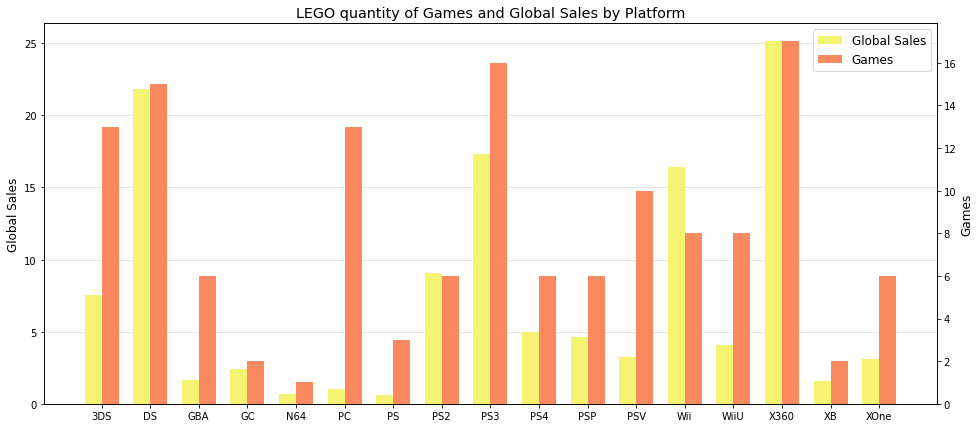

In [56]:
#Criamos o frame
plt.figure(figsize=(16,7))

#Criamos um array para a construção do eixo x
x = np.arange(len(lego_sales['Platform']))

#Definimos o tamanho de cada barra
barra=0.35

#Criamos os eixos "gêmeos", que dividem o eixo x e plotamos os gráficos, alterando manualmente sua posição para que não haja sobreposição
ax = plt.subplot(1,1,1)
sales =ax.bar(x, lego_sales['Global_Sales'], width=barra, color='#F5F472')
ax2 = ax.twinx()
games = ax2.bar(x + barra, lego_sales['Games'], width=barra, color='#FA895F')

#Detalhes, labels, etc.
plt.xticks(x + barra/2, lego_sales['Platform'])
ax.set_ylabel('Global Sales',size="large" )
ax2.set_ylabel('Games', size="large")
plt.legend([sales,games],['Global Sales','Games'],prop={'size': 12})
plt.title("LEGO quantity of Games and Global Sales by Platform", size="x-large")
ax.set_axisbelow(True)
ax.yaxis.grid(color='#E0DFDC')
plt.show()

A partir dessa plotagem é possível investigar a resposta do público dos investimentos da LEGO no mundo dos jogos. Por exemplo, os investimentos em jogos de DS e X360 tiveram um ótimo retorno, e os de Wii tiveram ainda mais sucesso quando comparados à quantidade de jogos produzidos! Na verdade, é a única plataforma em que esse evento ocorreu de forma tão intensa. Parece um erro, dessa forma, que a LEGO tenha produzido tantos jogos para o 3DS, por exemplo, e não tenha se dedicado ainda mais aos jogos de Wii.

Essa nova observação condiz, ainda, com o gráfico que vimos anteriormente. Os jogos de 7ª geração realmente contaram com muitas vendas- e em geral foram muito produzidos. Por outro lado, a quantidade de jogos de PC está entre as mais altas dentre as plataformas, enquanto as vendas são mínimas! Essa diferença é bem clara na plataforma, que está dentre as que possuem mais jogos. Essa inisitência que pode parecer, possivelmente, um erro da LEGO, é facilmente explicada pelo fato de que o database `vgsales` só considera vendas físicas do jogo, ou seja, no caso do PC, em CD. No entanto, para jogos de PC há a facilidade de comprar jogos remotamente em lojas como a Steam, e essa forma de distribuição digital se tornou muito popular. Suas vendas não estão contabilizadas aqui.

Temos interesse, agora, em analisar algumas subfranquias bem conhecidas da LEGO, comparando suas vendas regionais e globais. Para isso, inicialmente, faremos o reconhecimento desses jogos por palavras relevantes dentro das strings, criando subsets apenas com os jogos de cada subfranquia:

In [57]:
harry_potter = lego[(lego.Name.str.contains("Harry"))]
harry_potter.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
618,619,LEGO Harry Potter: Years 1-4,Wii,2010,Action,Warner Bros. Interactive Entertainment,1.29,0.97,0.0,0.23,2.49
671,673,LEGO Harry Potter: Years 1-4,DS,2010,Action,Warner Bros. Interactive Entertainment,1.07,1.05,0.0,0.23,2.35
1166,1168,LEGO Harry Potter: Years 1-4,X360,2010,Action,Warner Bros. Interactive Entertainment,0.95,0.50,0.0,0.14,1.59
1420,1422,LEGO Harry Potter: Years 1-4,PS3,2010,Action,Warner Bros. Interactive Entertainment,0.55,0.60,0.0,0.22,1.37
2886,2888,LEGO Harry Potter: Years 1-4,PSP,2010,Action,Warner Bros. Interactive Entertainment,0.14,0.37,0.0,0.19,0.71


O subset criado para jogos do 'Harry Potter' está acima como exemplo, mas faremos o mesmo para as outras subfranquias mais famosas da LEGO.

In [58]:
star_wars = lego[(lego.Name.str.contains("Star Wars"))]
indiana = lego[(lego.Name.str.contains("Indiana"))]
batman = lego[(lego.Name.str.contains("Batman"))]
marvel = lego[(lego.Name.str.contains("Marvel"))]

Agora podemos unir esses subsets em um único dataframe, realizando de uma vez a soma das vendas por regiões.

In [59]:
franq = pd.DataFrame({"Franchises" : ["Harry Potter", "Star Wars", "Indiana Jones", "Batman", "Marvel"],
        "Global" : [harry_potter["Global_Sales"].sum(), star_wars["Global_Sales"].sum(), indiana["Global_Sales"].sum(), batman["Global_Sales"].sum(),  marvel["Global_Sales"].sum()],
        "NA" : [harry_potter["NA_Sales"].sum(), star_wars["NA_Sales"].sum(), indiana["NA_Sales"].sum(), batman["NA_Sales"].sum(), marvel["NA_Sales"].sum()],
        "EU" : [harry_potter["EU_Sales"].sum(), star_wars["EU_Sales"].sum(), indiana["EU_Sales"].sum(), batman["EU_Sales"].sum(), marvel["EU_Sales"].sum()],
        "JP" : [harry_potter["JP_Sales"].sum(), star_wars["JP_Sales"].sum(), indiana["JP_Sales"].sum(), batman["JP_Sales"].sum(), marvel["JP_Sales"].sum()],
        "Other" : [harry_potter["Other_Sales"].sum(), star_wars["Other_Sales"].sum(), indiana["Other_Sales"].sum(), batman["Other_Sales"].sum(), marvel["Other_Sales"].sum()]})

franq

,Franchises,Global,NA,EU,JP,Other
0,Harry Potter,8.77,4.10,3.60,0.00,1.06
1,Star Wars,37.92,22.85,11.38,0.02,3.65
2,Indiana Jones,14.89,8.17,4.32,0.00,2.43
3,Batman,15.55,8.68,4.88,0.00,1.98
4,Marvel,12.12,5.37,5.14,0.09,1.52


É possível notar pela tabela como os jogos de Star Wars tem a maior aceitação em mercado. Faremos uma visualização simples para tornar a diferença mais visual:

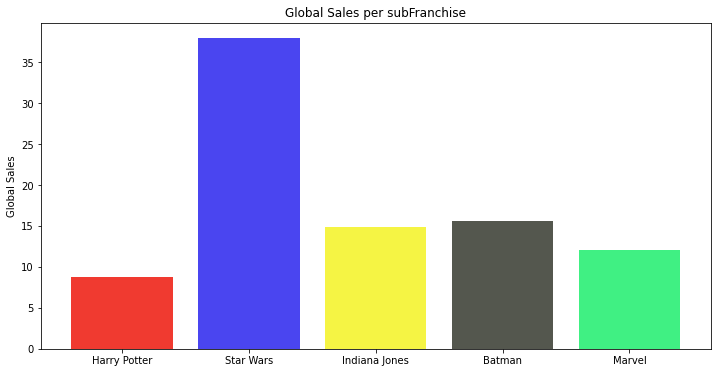

In [60]:
plt.figure(figsize=(12,6))
plt.bar(franq.Franchises, franq.Global, color=['#F03A30','#4A45F0' ,'#F5F444', '#54574E','#40F083'])
plt.ylabel("Global Sales")
plt.title("Global Sales per subFranchise")

plt.show()

As vendas globais da franquia Star Wars tem um destaque absoluto entre as outras. Faremos, então, um gráfico de radar apenas para essa franquia, com o objetivo de compreender sua distribuição entre as regiões de venda de jogos, e um comparativo entre as outras franquias, que têm escala mais próxima.

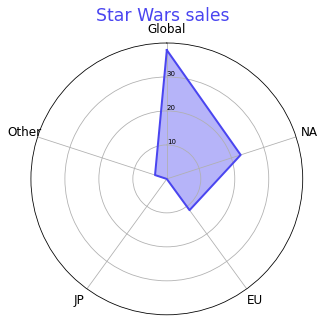

In [61]:
#Criamos o frame
plt.figure(figsize=(5,5))

# Definimos n com o número de variáveis analisadas (nesse caso as sales)
categorias=list(franq)[1:]
N = len(categorias)
  
#Definimos o ângulo em que cada sale será mostrado, são os eixos do que será um gráfico polar
angulo= [n / float(N) * 2 * np.pi for n in range(N)]
angulo += angulo[:1]
    
#Criamos o plot como polar e definimos a ordenação das regiões de vendas no gráfico    
ax = plt.subplot(111, polar=True)
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
    
#Detalhes de labels e escolha de escalas   
plt.xticks(angulo[:-1], categorias, color='black', size=8)
ax.set_rlabel_position(0)
plt.yticks([10,20,30], ["10","20","30"], color="black", size=7)
plt.ylim(0,40)
    
#Adição da representação dos dados, nesse caso de Star Wars    
valor = franq.loc[1].drop('Franchises').values.flatten().tolist()
valor += valor[:1]
ax.plot(angulo, valor, '#4A45F0', linewidth=2, linestyle='solid')
ax.fill(angulo, valor, '#4A45F0', alpha=0.4)
ax.tick_params(axis='x', labelsize='large')

plt.suptitle('Star Wars sales', size="xx-large", color='#4A45F0')
plt.show()

É possível estudar a distribuição da subfranquia a partir deste gráfico. Não há vendas na região do Japão, e a maior aceitação ocorre na América do Norte, como é de se esperar, uma vez que Star Wars tem produção inteiramente estadunidense. No entanto, as vendas europeias também são bem altas! Vamos visualizar a comparação entre as outras franquias:

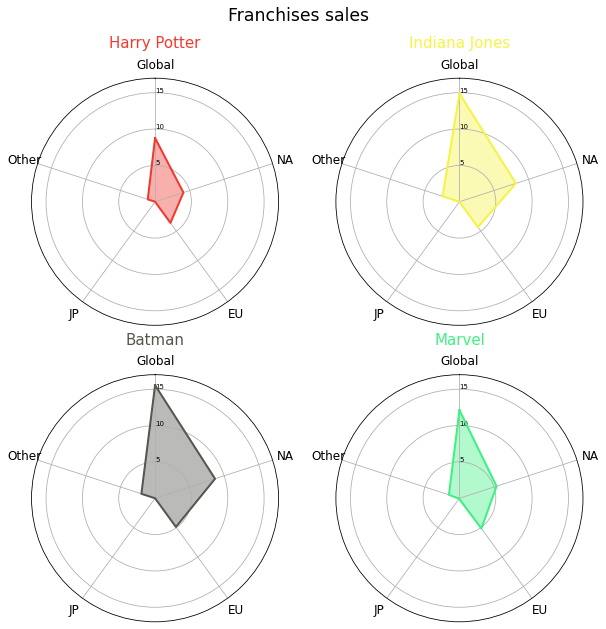

In [62]:
#Fazemos um drop dos dados de Star Wars para facilitar a plotagem, corrigindo o index
franq = franq[franq['Franchises'] != 'Star Wars']
franq.reset_index(drop=True, inplace=True)

#A ideia aqui é semelhante ao feito para a plotagem de Star Wars, mas definimos uma função que cria o gráfico para facilitar o processo
def radar(franquia, titulo, cor):
    categorias=list(franq)[1:]
    N = len(categorias)
    
    angulo= [n / float(N) * 2 * np.pi for n in range(N)]
    angulo += angulo[:1]
    
    ax = plt.subplot(2,2, franquia+1, polar=True)
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    
    plt.xticks(angulo[:-1], categorias, color='black', size=8) 
    ax.set_rlabel_position(0)
    plt.yticks([5,10,15], ["5","10","15"], color="black", size=7)
    plt.ylim(0,17)
    
    valor = franq.loc[franquia].drop('Franchises').values.flatten().tolist()
    valor += valor[:1]
    ax.plot(angulo, valor, color=cor, linewidth=2, linestyle='solid')
    ax.fill(angulo, valor, color=cor, alpha=0.4)
    ax.tick_params(axis='x', labelsize='large')
    
    #Definimos título internamente também para que os subplots sejam identificados
    plt.title(titulo, size=15, color=cor, y=1.1)
    

#Criamos a figura do plot
plt.figure(figsize=(10,10))

#Definimos uma paleta
paleta = np.array(['#F03A30','#F5F444', '#54574E','#40F083'])

#Criamos um loop de repetição que utiliza a função radar e cria os subplots
for franquia in range(0, len(franq.Franchises)):
    radar(franquia=franquia, titulo=''+franq['Franchises'][franquia], cor=paleta[franquia])

#Adicionamos o título do gráfico completo
plt.suptitle('Franchises sales', size="xx-large")    
plt.show()    

Vemos novamente a maior venda como a Global, claro, já que é a soma de todas as outras. Novamente não temos vendas JP, como havia sido exposto na própria tabela. 

Mas a comparação aqui demonstra fatos muito interessantes! Todos os jogos, dentre regiões específicas, têm prevalência de vendas na região NA, que é sabidamente o maior mercado de games. No entanto, enquanto os jogos do Indiana Jones e do Batman (e do Star Wars, como é possível visualizar no gráfico anterior), de criação norte americana, têm essa característica de forma acentuada (NA muito maior que outras regiões), os jogos de Harry Potter, de autoria britânica, têm quase um equilíbrio, sendo as vendas na Europa muito próximas às da America do Norte.

O fato mais surpreendente aqui é que os jogos da Marvel, também americana, seguem a tendência de Harry Potter, e não das outras produções americanas. Esse fato pode indicar um grande sucesso dos Vingadores (sequência de filmes representados nos jogos da LEGO da Marvel) no continente ou, uma vez que são (junto a Harry Potter), a franquia mais recente, indicar avanço da globalização. Essa situação pode explicar a aproximação das vendas NA e EU que ocorreu na última década conforme o gráfico de vendas por região através dos anos. Não sabemos, porém, a exata distribuição dessas vendas através dos anos. Por isso, vamos fazer outra plotagem:

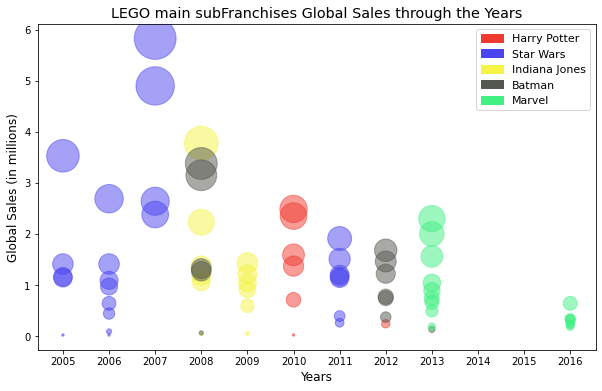

In [63]:
# Vamos retirar os valores NA dos subsets criados para cada subfranquia
franquias = [harry_potter, star_wars, indiana, batman, marvel]
for franquia in franquias:
    franquia = franquia[franquia.Year!= -1]

# Criamos o frame
plt.figure(figsize=(10, 6))

# Paleta
paleta=['#F03A30','#4A45F0' ,'#F5F444', '#54574E','#40F083']

# Fazemos os scatter plots, definindo o tamanho de cada ponto de acordo com as vendas globais por jogo e a cor de acordo com a mesma paleta 
franquias = [harry_potter, star_wars, indiana, batman, marvel]
n=0
for franquia in franquias:
    plt.scatter(franquia.Year, franquia.Global_Sales, s=300*franquia.Global_Sales, alpha=0.5, c=paleta[n])
    n=n+1
    

# Criamos a legenda pela ferramenta Patch do matplotlib.patches, já que pela função legend do matplotlib.pyplot a 
#legenda acompanhava o tamanho das "bolinhas"
hp = mpatches.Patch(color=paleta[0], label='Harry Potter')
sw = mpatches.Patch(color=paleta[1], label='Star Wars')
ind = mpatches.Patch(color=paleta[2], label='Indiana Jones')
bat = mpatches.Patch(color=paleta[3], label='Batman')
mv = mpatches.Patch(color=paleta[4], label='Marvel')

# Adicionamos mais detalhes
plt.xticks(np.arange(2005, 2017, 1.0))
plt.xlabel('Years',size="large")
plt.ylabel('Global Sales (in millions)',size="large")
plt.title('LEGO main subFranchises Global Sales through the Years', size="x-large")
plt.legend(handles=[hp, sw, ind, bat, mv],prop={'size': 11})
plt.show()

A época de lançamento dos jogos da Marvel, de fato, coincide com a aproximação entre as vendas da América do Norte e da Europa, assim como os jogos de Harry Potter, em 2010, são simultâneos a um crescimento considerável de vendas no continente europeu.

Aqui podemos visualizar, ainda, como o lançamento dos jogos de Star Wars foi prévio às outras franquias, o que pode ser um motivo de seu grande sucesso: a novidade. Até então, a LEGO não havia lançado jogos em parceria com séries de filmes

## Grand Theft Auto

Essa série de jogos popularmente conhecida como GTA está entre as mais populares mundialmente, e já lançou diversos jogos para multiplataformas. Vamos analisar um pouco do seu desempenho criando inicialmente um subset do database original filtrando pela str "Grand Theft Auto", presente em todos os nomes de jogos da série:

In [64]:
gta = vgsales[vgsales.Name.str.contains("Grand Theft Auto")]
gta.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
16,17,Grand Theft Auto V,PS3,2013,Action,Take-Two Interactive,7.01,9.27,0.97,4.14,21.40
17,18,Grand Theft Auto: San Andreas,PS2,2004,Action,Take-Two Interactive,9.43,0.40,0.41,10.57,20.81
23,24,Grand Theft Auto V,X360,2013,Action,Take-Two Interactive,9.63,5.31,0.06,1.38,16.38
24,25,Grand Theft Auto: Vice City,PS2,2002,Action,Take-Two Interactive,8.41,5.49,0.47,1.78,16.15
38,39,Grand Theft Auto III,PS2,2001,Action,Take-Two Interactive,6.99,4.51,0.30,1.30,13.10


Queremos, inicialmente, visualizar a evolução dos jogos de GTA através dos anos em relação a vendas globais para nos dar um panorama geral. Veja a seguir:

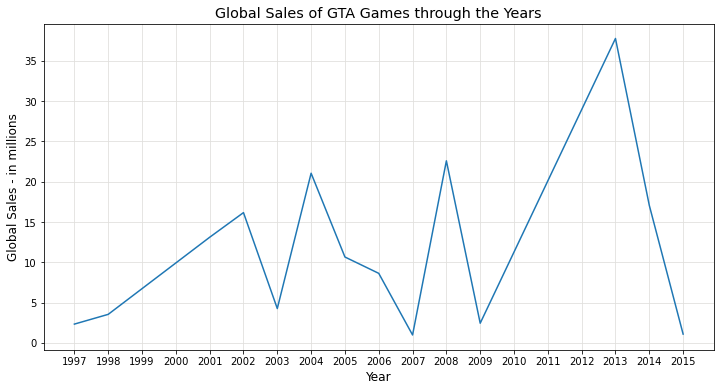

In [65]:
#Criamos um subset agrupando por ano e somando as vendas globais. Não há dados NA.
gta_y = gta.groupby(["Year"],as_index=False)[["Global_Sales"]].sum()

#Criamos o frame
plt.figure(figsize=(12, 6))

#Fazemos a plotagem
plt.plot(gta_y["Year"], gta_y["Global_Sales"])  

#Definindo os eixos e labels
plt.xticks(range(1997,2016))
plt.xlabel("Year", size="large")
plt.ylabel("Global Sales - in millions", size="large")
plt.title("Global Sales of GTA Games through the Years", size="x-large")
plt.grid(color='#E0DFDC')

plt.show()

As vendas são, realmente, surpreendentes, ultrapassando com facilidade as vendas dos jogos LEGO apresentada anteriormente. É bem notável pelo gráfico acima que as vendas do GTA se dão em grande parte por picos de venda, com o lançamento dos jogos melhor aceitos pelo público. 

Expandindo o dataframe `gta` criado acima foi possível descobrir todos os jogos da série GTA que tiveram um sucesso relevante. São eles:
* GTA Vice City
* GTA San Andreas
* GTA 2
* GTA III
* GTA IV
* GTA V

Vamos analisar a seguir as vendas de cada um desses filtrando pelas strings da coluna `Name`, buscando entender as épocas de lançamento e explicar os picos da plotagem anterior.

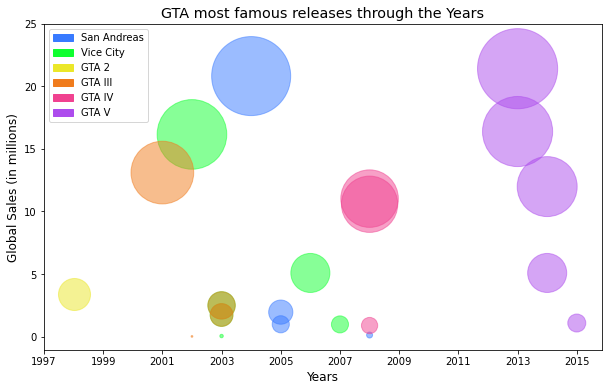

In [71]:
#Criamos a paleta desejada
paleta=['#387AFF','#10FF30', '#EBE729', '#F07C1D', '#F04290','#AD4CED']

#Vários subsets são criados, filtrando pela string desejada para captar os lançamentos de cada jogo
sa = gta[(gta.Name.str.contains("San Andreas"))]
vc = gta[(gta.Name.str.contains("Vice City"))]
gta_2 = gta[(gta.Name.str.contains("2"))]
gta_III = gta[(gta.Name.str.contains("III"))]
gta_IV = gta[(gta.Name.str.contains("IV"))]
gta_V = gta[(gta.Name.str.contains("V"))& ~(gta.Name.str.contains("IV"))& ~(gta.Name.str.contains("Vice"))]

#Criamos o frame
plt.figure(figsize=(10, 6))

#Fazemos os scatter plots, definindo o tamanho de cada ponto de acordo com as vendas globais por jogo e a cor segundo a paleta 
franquias = [sa, vc, gta_2, gta_III, gta_IV, gta_V]
n=0
for franquia in franquias:
    plt.scatter(franquia.Year, franquia.Global_Sales, s=300*franquia.Global_Sales, alpha=0.5, c=paleta[n])
    n=n+1
    
#Criamos a legenda pela ferramenta Patch
s = mpatches.Patch(color=paleta[0], label='San Andreas')
v = mpatches.Patch(color=paleta[1], label='Vice City')
g2 = mpatches.Patch(color=paleta[2], label='GTA 2')
III = mpatches.Patch(color=paleta[3], label='GTA III')
IV = mpatches.Patch(color=paleta[4], label='GTA IV')
V = mpatches.Patch(color=paleta[5], label='GTA V')

#Adicionamos mais detalhes
plt.xticks(np.arange(1997, 2016, 2))
plt.yticks(np.arange(0, 30, 5))
plt.xlabel('Years',size="large")
plt.ylabel('Global Sales (in millions)',size="large")
plt.title('GTA most famous releases through the Years', size="x-large")
plt.legend(handles=[s, v,g2, III, IV, V],prop={'size': 10}, loc= 'upper left')

plt.show()

Cada jogo, aqui, pode ter mais de uma "bolinha" já que estão separados por plataforma, e, agora, as tendências do gráfico anterior ficam bem claras!

A primeira escalada repentina pode ser explicada pelo grande sucesso do GTA III e GTA Vice City em 2001 e 2002 respectivamente. Há uma queda no ano seguinte em que as vendas realmente são baixas (inclusive é interessante destacar que os dois cículos de cor peculiar em 2003 são a mistura de verde e laranja , já que para cada um há dois círculos idênticos, uma vez que houve o lançamento de uma edição limitada que continha o GTA Vice City e GTA III).

Logo em 2004, o lançamento do GTA San Andreas explica o pico no gráfico anterior. Apesar de estar mais abaixo nesse gráfico por ser dividido em duas plataformas de sucesso, o GTA IV teve vendas o suficiente para justificar o terceiro pico. Por fim, as altíssimas vendas do GTA V são visíveis! Representam o valor máximo alcançado no gráfico anterior e uma área imensa neste gráfico!

Como mencionamos a questão das plataformas, é interessante buscar visualizá-las e explorar sua comparação com as vendas:

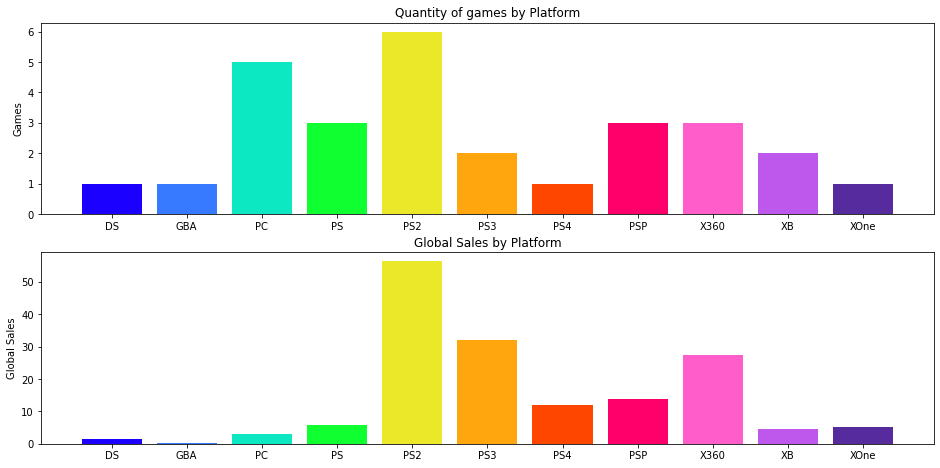

In [72]:
# Criamos dois subsets que fazem, agrupando por plataforma, e, respectivamente, contabilizando os jogos e somando as vendas globais
gta_plat = gta.groupby("Platform",as_index=False)[["Name"]].count()
gta_salesyear = gta.groupby("Platform",as_index=False)[["Global_Sales"]].sum()

# Nova paleta
paleta=['#1B00FF','#387AFF','#0CE8C2', '#10FF30', '#EBE729', '#FFA60F', '#FF4600', '#FF006A', '#FF5DC9', '#BE57EB', '#552B9E']

# Criamos a figura e os axs para subplotagem
fig, axs = plt.subplots(2, 1, figsize=(16, 6))

# Definimos os dois subplots, ambos com o mesmo eixo x de plataformas, sendo o primeiro a contagem de jogos e o segundo as vendas globais
axs[0].bar(gta_plat.Platform, gta_plat.Name, color=paleta)
axs[1].bar(gta_salesyear.Platform, gta_salesyear.Global_Sales, color=paleta)

# Lidamos com posições e labels
plt.subplots_adjust(top=1.1)
axs[0].title.set_text('Quantity of games by Platform')
axs[0].set_ylabel('Games')
axs[1].title.set_text('Global Sales by Platform')
axs[1].set_ylabel('Global Sales')

plt.show()

A princípio a comparação do PC pode assustar, mas ocorreu o mesmo que na plotagem da LEGO, ou seja, não estamos contabilizando as vendas em plataformas digitais. Fora esse ponto, é possível observar as baixas vendas para PlayStation (em comparação à produção de games para a plataforma e o retorno obtido por outras), enquanto o PS2 correspondeu às expectativas nele depositadas! Foi a plataforma que teve mais desenvolvimentos e, também, mais vendas globais. 

Para o PS3 e Xbox houve uma pequena vantagem das vendas em relação à produção, mas sem absurda notabilidade. O gráfico evidencia, ainda, que o GTA é majoritariamente vendido para consoles de mesa. Vamos por fim fazer uma rápida análise das vendas de jogos GTA por região:

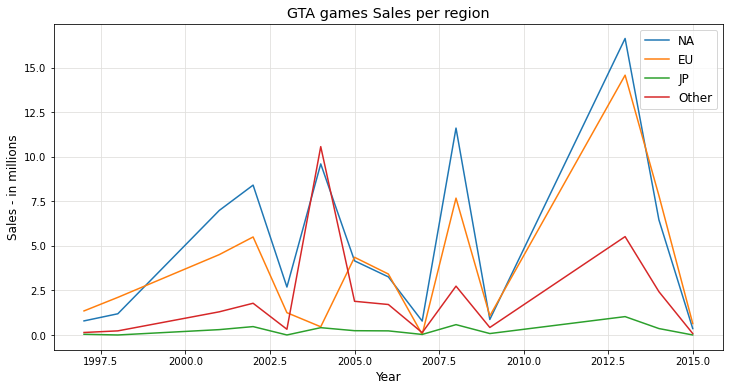

In [73]:
#Criamos o frame
plt.figure(figsize=(12, 6))

#Agrupamos novamente por ano as vendas de cada região e plotamos (linha é o formato padrão)
gta.groupby('Year')['NA_Sales'].sum().plot(label="NA")
gta.groupby('Year')['EU_Sales'].sum().plot(label="EU")
gta.groupby('Year')['JP_Sales'].sum().plot(label="JP")
gta.groupby('Year')['Other_Sales'].sum().plot(label="Other")

#Adição de detalhes, legendas...
plt.legend(prop={'size': 12})
plt.title("GTA games Sales per region", size="x-large")
plt.xlabel("Year", size="large")
plt.ylabel("Sales - in millions", size="large")
plt.grid(color='#E0DFDC')

plt.show()

Esse resultado foi uma surpresa! Esperávamos uma grande predominância de vendas no mercado NA mas a realidade é surpreendentemente equilibrada. Em geral, todas as regiões (exceto a JP, que praticamente não tem participação nas vendas) acompanham os destaques com alguns destaques. O mercado nomeado como 'Other' parece ter uma preferência pelo GTA San Andreas, já que é o único ponto em que este alcança o pico da América do Norte. Surpreendentemente, a Europa teve vendas baixíssimas nesse mesmo ano, o que indica que esse jogo não foi bem recebido.

O GTA V, no entanto, praticamente iguala vendas NA e EU em valores muito altos! A franquia GTA é, definitivamente, um sucesso mundial.